In [1]:
import os
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import random

In [2]:
# Detectar dispositivo (mac em casa)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [ ]:
# Caminhos
base_dir = Path("C:\\temp\\drones\\classes")
classes = [d.name for d in base_dir.iterdir() if d.is_dir()]

# número de arquivos por classe
print("Número de arquivos por classe:")
file_counts = {cls: len(list((base_dir / cls).glob("*.tif"))) for cls in classes}
for cls, count in file_counts.items():
    print(f"{cls}: {count}")

Número de arquivos por classe:
areia: 55600
restinga: 82904


In [4]:
# Definir número de amostras
samples_per_class = 10000
if samples_per_class > 0:
    print(f"Selecionando aleatoriamente {samples_per_class} amostras por classe...")
else:
    print("Usando todas as amostras disponíveis.")

Selecionando aleatoriamente 10000 amostras por classe...


In [ ]:
# Selecionar amostras
datasets_by_class = {}
for cls in classes:
    class_dir = base_dir / cls
    all_files = list(class_dir.glob("*.tif"))  # Apenas arquivos .tif
    selected_files = random.sample(all_files, min(samples_per_class, len(all_files))) if samples_per_class > 0 else all_files
    datasets_by_class[cls] = selected_files

# Criar um dataset combinado a partir das amostras selecionadas
selected_images = []
selected_labels = []
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

for cls, files in datasets_by_class.items():
    selected_images.extend(files)
    selected_labels.extend([class_to_idx[cls]] * len(files))

# rotação
class RandomRotation90:
    def __call__(self, img):
        rotations = random.choice([0, 1, 2, 3])  # 0: 0°, 1: 90°, 2: 180°, 3: 270°
        return img.rotate(90 * rotations)

# Normalizar e preparar os dados
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    RandomRotation90(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Dataset
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert("RGB")  # Tenta abrir o arquivo como RGB
        except Exception as e:
            print(f"Erro ao abrir a imagem {self.image_paths[idx]}: {e}")
            raise e
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

full_dataset = CustomImageDataset(selected_images, selected_labels, transform=train_transform)


In [6]:
# Dividir dataset em treino e validação
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Modelo pré-treinado para classificação (ResNet-18)
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, len(classes))  # Ajustar a saída para o número de classes
model = model.to(device)

# Função de perda, otimizador e treinamento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

train_loss_history = []
val_accuracy_history = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss_history.append(train_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}")

    # Validação
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_accuracy = correct / total
    val_accuracy_history.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/10, Training Loss: 62.7779
Validation Accuracy: 0.9835
Epoch 2/10, Training Loss: 48.3749
Validation Accuracy: 0.9872
Epoch 3/10, Training Loss: 44.0848
Validation Accuracy: 0.9888
Epoch 4/10, Training Loss: 36.4676
Validation Accuracy: 0.9910
Epoch 5/10, Training Loss: 37.7342
Validation Accuracy: 0.9892
Epoch 6/10, Training Loss: 37.9933
Validation Accuracy: 0.9858
Epoch 7/10, Training Loss: 34.0863
Validation Accuracy: 0.9915
Epoch 8/10, Training Loss: 30.1101
Validation Accuracy: 0.9912
Epoch 9/10, Training Loss: 30.1652
Validation Accuracy: 0.9910
Epoch 10/10, Training Loss: 30.2226
Validation Accuracy: 0.9915


In [7]:
# Salvar modelo
torch.save(model.state_dict(), "resnet18_modelo_classificado_restinga_areia.pth")

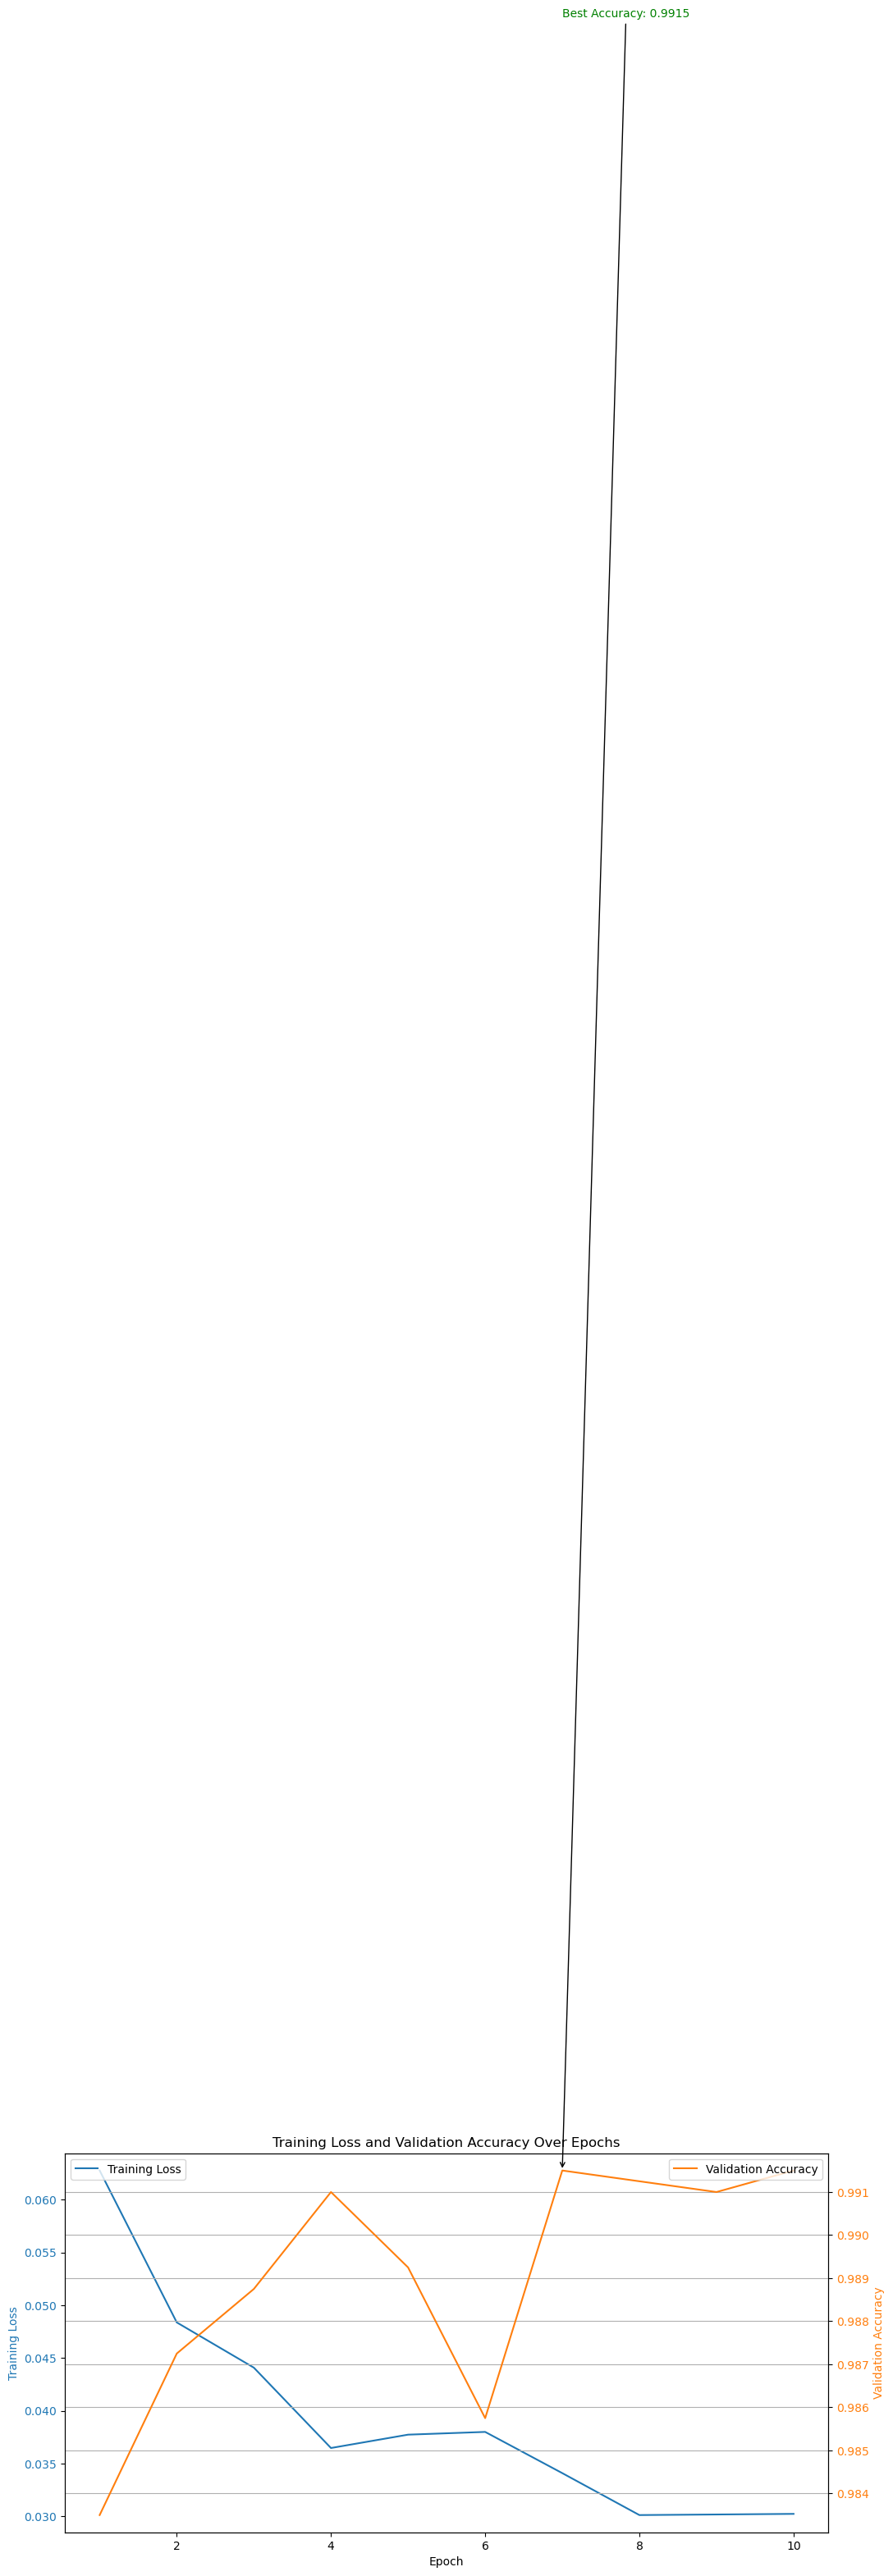

In [ ]:
# Gráfico de progresso
fig, ax1 = plt.subplots(figsize=(12, 6))

# Eixo esquerdo (Training Loss)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Training Loss", color="tab:blue")
ax1.plot(range(1, epochs + 1), train_loss_history, label="Training Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.legend(loc="upper left")

# Eixo direito (Validation Accuracy)
ax2 = ax1.twinx()
ax2.set_ylabel("Validation Accuracy", color="tab:orange")
ax2.plot(range(1, epochs + 1), val_accuracy_history, label="Validation Accuracy", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")
ax2.legend(loc="upper right")

# Título e grade
plt.title("Training Loss and Validation Accuracy Over Epochs")
plt.grid()

# Teste add melhores resultados no gráfico
best_epoch = val_accuracy_history.index(max(val_accuracy_history)) + 1
plt.annotate(f"Best Accuracy: {max(val_accuracy_history):.4f}",
             xy=(best_epoch, max(val_accuracy_history)),
             xytext=(best_epoch, max(val_accuracy_history) + 0.05),
             arrowprops=dict(facecolor="black", arrowstyle="->"),
             fontsize=10, color="green")

plt.show()

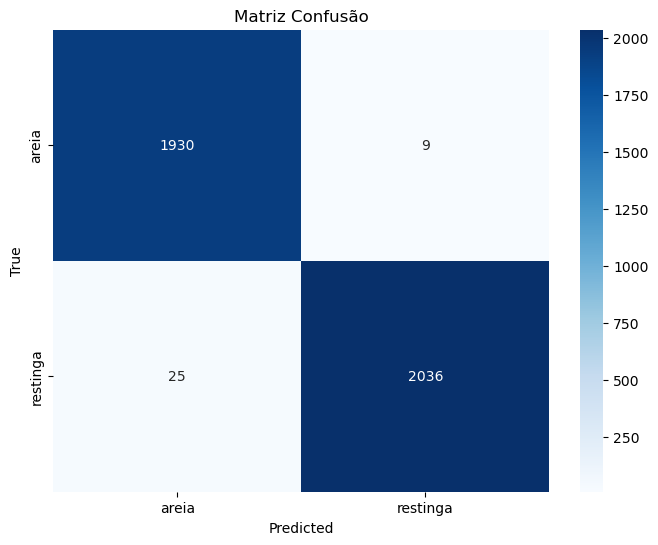

Classification Report:
              precision    recall  f1-score   support

       areia       0.99      1.00      0.99      1939
    restinga       1.00      0.99      0.99      2061

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



In [ ]:
# Matriz de confusão e relatório de classificação
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Matriz Confusão")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Classification Report:")
print(class_report)